In [1]:
# please ignore warning messages during the installation
!pip install --disable-pip-version-check -q sagemaker==2.35.0
!pip install --disable-pip-version-check -q pandas==1.1.4
!pip install --disable-pip-version-check -q awswrangler==2.7.0
!pip install --disable-pip-version-check -q numpy==1.18.5
!pip install --disable-pip-version-check -q seaborn==0.11.0
!pip install --disable-pip-version-check -q matplotlib===3.3.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2022.11.0 requires pandas>=1.3, but you have pandas 1.1.4 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
xarray 2022.11.0 requires pandas>=1.3, but you have pandas 1.1.4 which is incompatible.
tensorflow-intel 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.20.3 which is incompatible.
jax 0.4.10 requires numpy>=1.21, but you have numpy 1.20.3 which is incompatible.
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [198 lines of output]
      Running from numpy source directory.
      <string>:461: UserWarning: U

In [2]:
import pandas as pd
import csv

df = pd.read_csv('womens_clothing_ecommerce_reviews.csv', index_col=0)

df.shape

(23486, 10)

In [3]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,847,33,"Cute, crisp shirt",If this product was in petite i would get the...,4,1,2,General,Tops,Blouses
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,I love love love this jumpsuit. it's fun fl...,5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Clothing ID,23486,NaN,NaN,NaN,918.119,203.299,0,861,936,1078,1205
Age,23486,NaN,NaN,NaN,43.1985,12.2795,18,34,41,52,99
Title,19676,13993,Love it!,136,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Review Text,22641,22634,Perfect fit and i've gotten so many compliment...,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Rating,23486,NaN,NaN,NaN,4.19603,1.11003,1,4,5,5,5
Recommended IND,23486,NaN,NaN,NaN,0.822362,0.382216,0,1,1,1,1
Positive Feedback Count,23486,NaN,NaN,NaN,2.53594,5.7022,0,0,1,3,122
Division Name,23472,3,General,13850,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Department Name,23472,6,Tops,10468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Class Name,23472,20,Dresses,6319,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.isna().sum().sort_values(ascending = False)


Title                      3810
Review Text                 845
Class Name                   14
Department Name              14
Division Name                14
Positive Feedback Count       0
Recommended IND               0
Rating                        0
Age                           0
Clothing ID                   0
dtype: int64

In [15]:
df_transformed = df.rename(columns={'Review Text': 'review_body',
                                    'Rating': 'star_rating',
                                    'Class Name': 'product_category'})
df_transformed.drop(columns=['Clothing ID', 'Age', 'Title', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name'],
                    inplace=True)

df_transformed.dropna(inplace=True)

df_transformed.shape

(22628, 3)

In [16]:
df_transformed.head()

,review_body,star_rating,product_category
0,If this product was in petite i would get the...,4,Blouses
1,Love this dress! it's sooo pretty. i happene...,5,Dresses
2,I had such high hopes for this dress and reall...,3,Dresses
3,I love love love this jumpsuit. it's fun fl...,5,Pants
4,This shirt is very flattering to all due to th...,5,Blouses


In [17]:
def to_sentiment(star_rating):
    if star_rating in {1, 2}: # negative
        return -1 
    if star_rating == 3:      # neutral
        return 0
    if star_rating in {4, 5}: # positive
        return 1
    

df_transformed['sentiment'] = df_transformed['star_rating'].apply(lambda star_rating: 
    to_sentiment(star_rating=star_rating) 
)

# drop the star rating column
df_transformed.drop(columns=['star_rating'],
                    inplace=True)


# remove reviews for product_categories with < 10 reviews
df_transformed = df_transformed.groupby('product_category').filter(lambda reviews : len(reviews) > 10)[['sentiment', 'review_body', 'product_category']]

df_transformed.shape

(22626, 3)

In [18]:
df_transformed.to_csv('womens_clothing_ecommerce_reviews_transformed.csv', 
                      index=False)

###  Register S3 dataset files as a table for querying


In [20]:
!pip install --disable-pip-version-check -q sagemaker==2.35.0

In [22]:
!pip install protobuf==3.20.0

^C


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\ACER\\anaconda3\\Lib\\site-packages\\google\\~upb\\_message.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



     -------------------------------------- 904.1/904.1 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.1
    Uninstalling protobuf-4.23.1:
      Successfully uninstalled protobuf-4.23.1


In [23]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
!pip install sagemaker --upgrade

     -------------------------------------- 853.5/853.5 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 61.2/61.2 kB 3.2 MB/s eta 0:00:00
     ---------------------------------------- 79.8/79.8 kB 1.5 MB/s eta 0:00:00
     -------------------------------------- 132.9/132.9 kB 4.0 MB/s eta 0:00:00
     ---------------------------------------- 52.8/52.8 kB 1.4 MB/s eta 0:00:00
  Created wheel for sagemaker: filename=sagemaker-2.171.0-py2.py3-none-any.whl size=1160921 sha256=9aeff33552e5920df294e1940f76a944a8f67ba03a3c5b0ff88a5d2991d268cd
  Stored in directory: c:\users\acer\appdata\local\pip\cache\wheels\3c\8e\20\06814d7ebbf7dfd55e030433a27d5d6c6c24bd4a9a24f7c43d
Successfully built sagemaker
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.0.0
    Uninstalling cloudpickle-2.0.0:
      Successfully uninstalled cloudpickle-2.0.0
  Att

In [27]:
pip install --upgrade botocore

Note: you may need to restart the kernel to use updated packages.


In [4]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import botocore

# config = botocore.config.Config(user_agent_extra='dlai-pds/c1/w1')

# low-level service client of the boto3 session
sm_boto3 = boto3.client("sagemaker")

sess = sagemaker.Session()                         

bucket = 'mobucketsagemaker'
# role = sagemaker.get_execution_role()
region = sess.boto_session.region_name
# account_id = sess.account_id

print('S3 Bucket: {}'.format(bucket))
print('Region: {}'.format(region))
# print('Account ID: {}'.format(account_id))

S3 Bucket: mobucketsagemaker
Region: us-east-1


In [6]:
!aws s3 cp ./womens_clothing_ecommerce_reviews_transformed.csv s3://$bucket/data/transformed/womens_clothing_ecommerce_reviews_transformed.csv

Completed 256.0 KiB/6.9 MiB (88.6 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/6.9 MiB (112.3 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/6.9 MiB (128.1 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/6.9 MiB (141.7 KiB/s) with 1 file(s) remaining  
Completed 1.2 MiB/6.9 MiB (149.0 KiB/s) with 1 file(s) remaining  
Completed 1.5 MiB/6.9 MiB (155.8 KiB/s) with 1 file(s) remaining  
Completed 1.8 MiB/6.9 MiB (161.6 KiB/s) with 1 file(s) remaining  
Completed 2.0 MiB/6.9 MiB (166.6 KiB/s) with 1 file(s) remaining  
Completed 2.2 MiB/6.9 MiB (170.0 KiB/s) with 1 file(s) remaining  
Completed 2.5 MiB/6.9 MiB (172.9 KiB/s) with 1 file(s) remaining  
Completed 2.8 MiB/6.9 MiB (176.8 KiB/s) with 1 file(s) remaining  
Completed 3.0 MiB/6.9 MiB (179.3 KiB/s) with 1 file(s) remaining  
Completed 3.2 MiB/6.9 MiB (181.3 KiB/s) with 1 file(s) remaining  
Completed 3.5 MiB/6.9 MiB (183.0 KiB/s) with 1 file(s) remaining  
Completed 3.8 MiB/6.9 MiB (184.5 KiB/s) with 1 file(s) remainin

In [7]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/buckets/{}?region={}&prefix=data/transformed/#">Amazon S3 buckets</a></b>'.format(bucket, region)))

C:\Users\ACER\AppData\Local\Temp\ipykernel_3848\1628230508.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [8]:
import awswrangler as wr

In [9]:
wr.catalog.create_database(
    name='dsoaws_deep_learning',
    exist_ok=True
)# ceating a database 

In [10]:
dbs = wr.catalog.get_databases()

for db in dbs:
    print("Database name: " + db['Name'])

Database name: dsoaws_deep_learning


In [11]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://console.aws.amazon.com/glue/home?region={}#catalog:tab=databases">AWS Glue Databases</a></b>'.format(region)))

C:\Users\ACER\AppData\Local\Temp\ipykernel_3848\2996986658.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [14]:
wr.catalog.create_csv_table(
    
    database='dsoaws_deep_learning', 
    
    path='s3://{}/data/transformed/'.format(bucket), 
    table="reviews",    
    columns_types={
        'sentiment': 'int',        
        'review_body': 'string',
        'product_category': 'string'      
    },
    mode='overwrite',
    skip_header_line_count=1,
    sep=','
)

In [15]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://console.aws.amazon.com/glue/home?region={}#">AWS Glue Catalog</a></b>'.format(region)))

C:\Users\ACER\AppData\Local\Temp\ipykernel_3848\19572356.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [16]:
table = wr.catalog.table(database='dsoaws_deep_learning',
                         table='reviews')
table

,Column Name,Type,Partition,Comment
0,sentiment,int,False,
1,review_body,string,False,
2,product_category,string,False,


### Create S3 bucket for Amazon Athena

In [17]:
# S3 bucket name
wr.athena.create_athena_bucket()

's3://aws-athena-query-results-461481678519-us-east-1/'

### Data visualization

In [18]:
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [20]:

database_name = 'dsoaws_deep_learning'
table_name = 'reviews'

In [21]:
sns.set_style = 'seaborn-whitegrid'

sns.set(rc={"font.style":"normal",
            "axes.facecolor":"white",
            'grid.color': '.8',
            'grid.linestyle': '-',
            "figure.facecolor":"white",
            "figure.titlesize":20,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":True,
            'axes.labelsize':10,
            'xtick.labelsize':10,
            'font.size':10,
            'ytick.labelsize':10})

In [22]:
#running sql queries in athena

statement_count_by_sentiment = """
SELECT sentiment, COUNT(sentiment) AS count_sentiment
FROM reviews
GROUP BY sentiment
ORDER BY sentiment
"""

# print(statement_count_by_sentiment)

In [23]:
df_count_by_sentiment = wr.athena.read_sql_query(
    sql=statement_count_by_sentiment,
    database=database_name
)

print(df_count_by_sentiment)

   sentiment  count_sentiment
0         -1             2370
1          0             2823
2          1            17433


<AxesSubplot:xlabel='sentiment'>

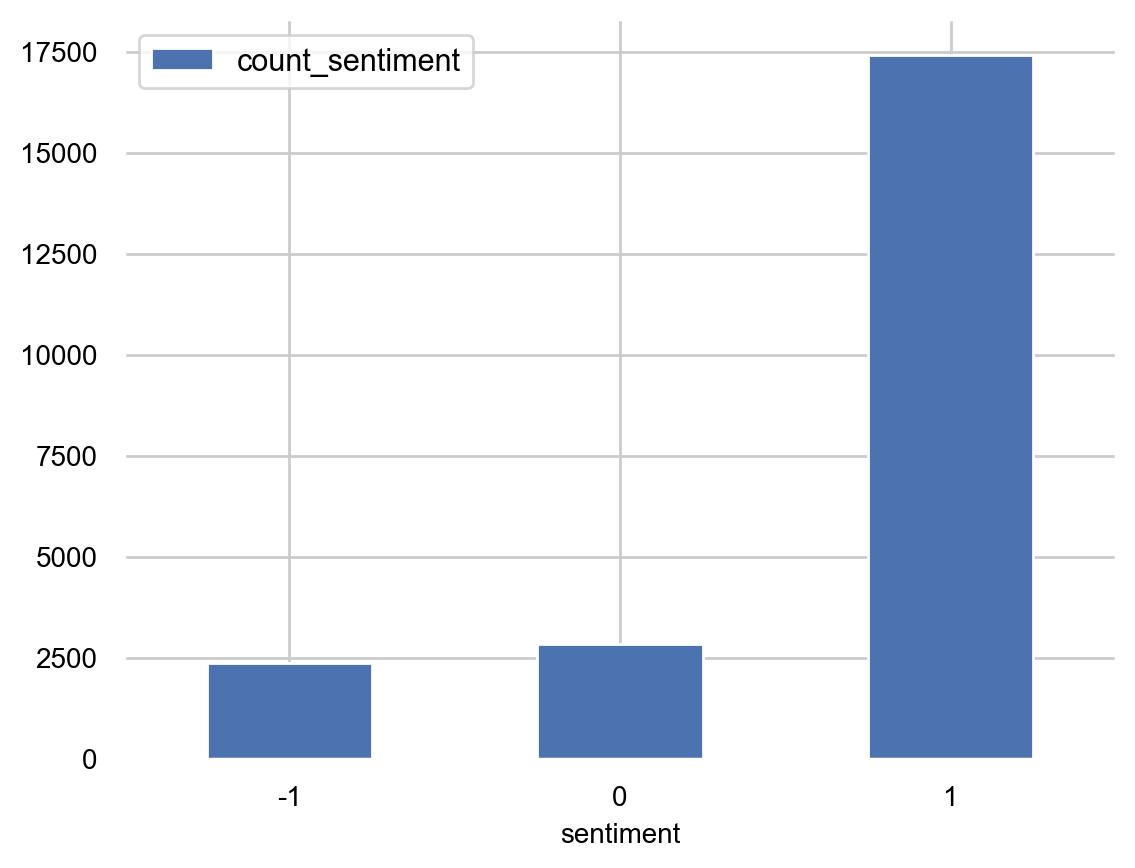

In [25]:
df_count_by_sentiment.plot(kind='bar', x='sentiment', y='count_sentiment', rot=0)

In [26]:
statement_count_by_category = """
SELECT product_category, COUNT(product_category) AS count_product_cat
FROM reviews
GROUP BY product_category 
ORDER BY product_category DESC
"""

In [28]:
df_count_by_category = wr.athena.read_sql_query(
    database = database_name,
    sql = statement_count_by_category
)

In [30]:
df_count_by_category

,product_category,count_product_cat
0,Trend,118
1,Swim,332
2,Sweaters,1380
3,Sleep,214
4,Skirts,903
5,Shorts,304
6,Pants,1350
7,Outerwear,319
8,Lounge,669
9,Legwear,158


In [32]:
# highest rated by average sentiment
statement_avg_by_category = """
SELECT product_category, AVG(sentiment) AS avg_sentiment
FROM {} 
GROUP BY product_category 
ORDER BY avg_sentiment DESC
""".format(table_name)

print(statement_avg_by_category)

# %%time
df_avg_by_category = wr.athena.read_sql_query(
    sql=statement_avg_by_category,
    database=database_name
)


SELECT product_category, AVG(sentiment) AS avg_sentiment
FROM reviews 
GROUP BY product_category 
ORDER BY avg_sentiment DESC



In [38]:
df_avg_by_category

,product_category,avg_sentiment
0,Layering,0.780303
1,Jeans,0.746377
2,Lounge,0.745889
3,Sleep,0.710280
4,Shorts,0.707237
5,Pants,0.705185
6,Intimates,0.700680
7,Jackets,0.699854
8,Skirts,0.696567
9,Legwear,0.696203


In [35]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()),2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

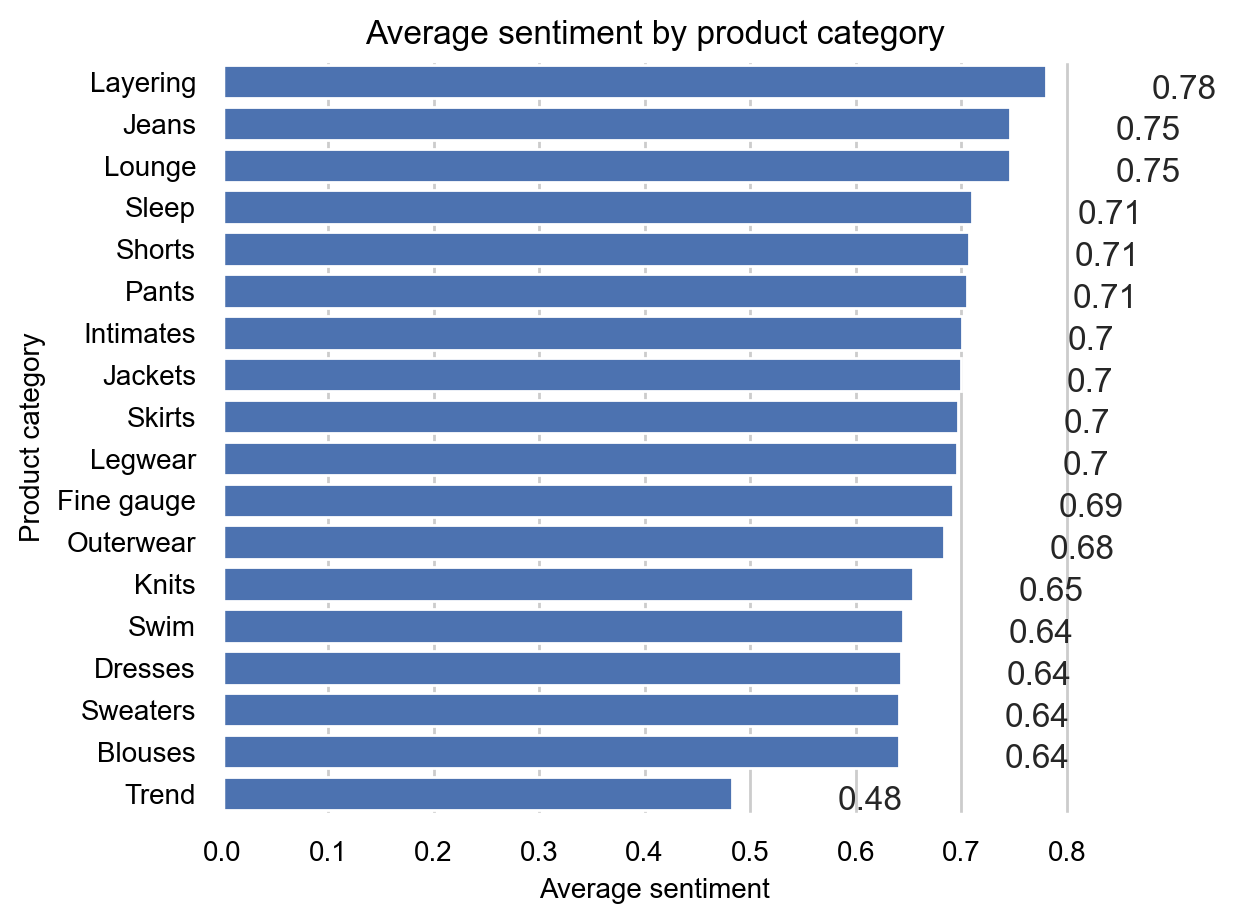

In [39]:
# Create plot
barplot = sns.barplot(
    data = df_avg_by_category, 
    y='product_category',
    x='avg_sentiment', 
    color="b", 
    saturation=1
)

# Set the size of the figure
sns.set(rc={'figure.figsize':(15.0, 10.0)})
    
# Set title and x-axis ticks 
plt.title('Average sentiment by product category')
#plt.xticks([-1, 0, 1], ['Negative', 'Neutral', 'Positive'])

# Helper code to show actual values afters bars 
show_values_barplot(barplot, 0.1)

plt.xlabel("Average sentiment")
plt.ylabel("Product category")

plt.tight_layout()
# Do not change the figure name - it is used for grading purposes!
plt.savefig('avg_sentiment_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

In [40]:
# Upload image to S3 bucket
sess.upload_data(path='avg_sentiment_per_category.png', bucket=bucket, key_prefix="images")

's3://mobucketsagemaker/images/avg_sentiment_per_category.png'

In [46]:
# to get product with most reviews
statement_count_by_category_desc = """
SELECT product_category, COUNT(*) AS count_reviews 
FROM {}
GROUP BY product_category 
ORDER BY count_reviews DESC
""".format(table_name)

print(statement_count_by_category_desc)


SELECT product_category, COUNT(*) AS count_reviews 
FROM reviews
GROUP BY product_category 
ORDER BY count_reviews DESC



In [47]:
%%time
df_count_by_category_desc = wr.athena.read_sql_query(
    sql=statement_count_by_category_desc,
    database=database_name
)

CPU times: total: 422 ms
Wall time: 9.55 s


In [48]:
max_sentiment = df_count_by_category_desc['count_reviews'].max()
print('Highest number of reviews (in a single category): {}'.format(max_sentiment))

Highest number of reviews (in a single category): 6145


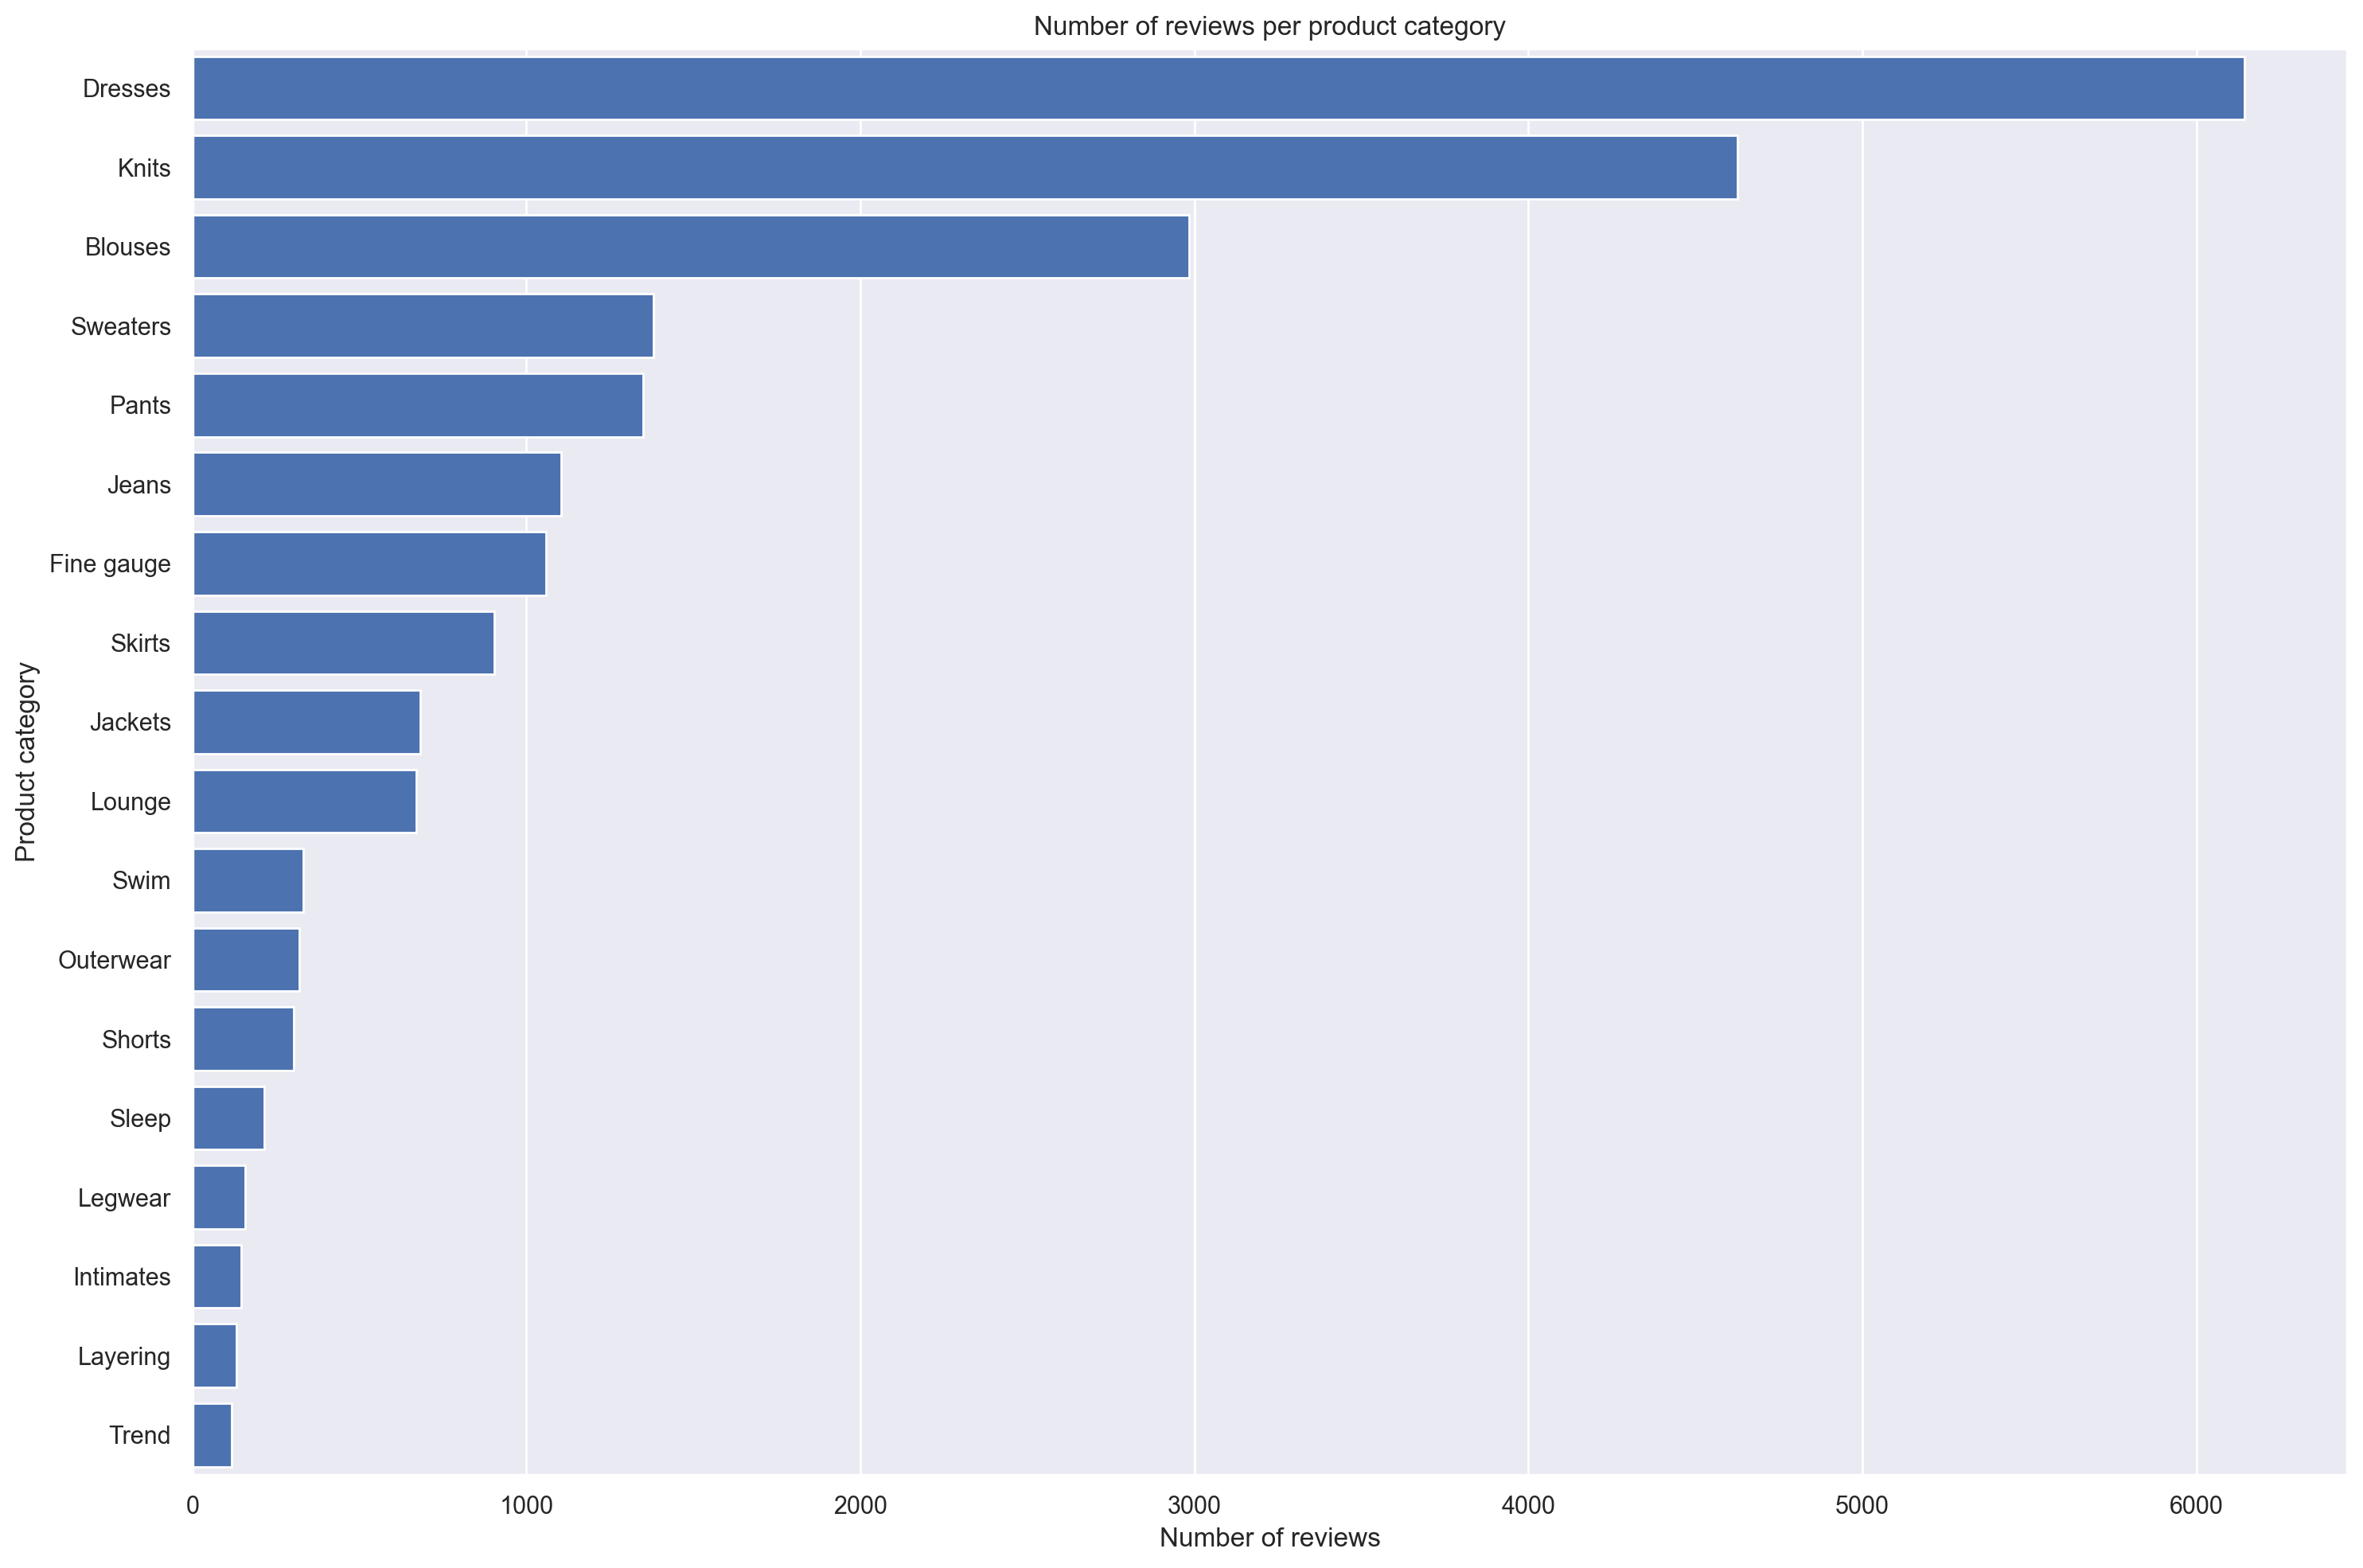

In [49]:
# Create seaborn barplot
barplot = sns.barplot(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    data=df_count_by_category_desc, # Replace None
    y='product_category', # Replace None
    x='count_reviews', # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    color="b",
    saturation=1
)

# Set the size of the figure
sns.set(rc={'figure.figsize':(15.0, 10.0)})
    
# Set title
plt.title("Number of reviews per product category")
plt.xlabel("Number of reviews")
plt.ylabel("Product category")

plt.tight_layout()

# Do not change the figure name - it is used for grading purposes!
plt.savefig('num_reviews_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

In [50]:
# Upload image to S3 bucket
sess.upload_data(path='num_reviews_per_category.png', bucket=bucket, key_prefix="images")

's3://mobucketsagemaker/images/num_reviews_per_category.png'

In [52]:
#breakdown of sentiment per product category

statement_count_by_category_and_sentiment = """
SELECT product_category,
         sentiment,
         COUNT(*) AS count_reviews
FROM {}
GROUP BY  product_category, sentiment
ORDER BY  product_category ASC, sentiment DESC, count_reviews
""".format(table_name)

print(statement_count_by_category_and_sentiment)


SELECT product_category,
         sentiment,
         COUNT(*) AS count_reviews
FROM reviews
GROUP BY  product_category, sentiment
ORDER BY  product_category ASC, sentiment DESC, count_reviews



In [ ]:
%%time
df_count_by_category_and_sentiment = wr.athena.read_sql_query(
    sql=statement_count_by_category_and_sentiment,
    database=database_name
)

In [53]:
%%time
df_count_by_category_and_sentiment = wr.athena.read_sql_query(
    sql=statement_count_by_category_and_sentiment,
    database=database_name
)

CPU times: total: 328 ms
Wall time: 9.56 s


stacked percentage horizontal bar plot showing proportion of sentiments per product category

In [54]:
# Create grouped dataframes by category and by sentiment
grouped_category = df_count_by_category_and_sentiment.groupby('product_category')
grouped_star = df_count_by_category_and_sentiment.groupby('sentiment')

# Create sum of sentiments per star sentiment
df_sum = df_count_by_category_and_sentiment.groupby(['sentiment']).sum()

# Calculate total number of sentiments
total = df_sum['count_reviews'].sum()
print('Total number of reviews: {}'.format(total))

Total number of reviews: 22626


In [59]:
#dictionary of product categories and array of star rating distribution per category.

distribution = {}
count_reviews_per_star = []
i=0

for category, sentiments in grouped_category:
    count_reviews_per_star = []
    for star in sentiments['sentiment']:
        count_reviews_per_star.append(sentiments.at[i, 'count_reviews'])
        i=i+1
    distribution[category] = count_reviews_per_star

In [57]:
distribution

{'Blouses': [2256, 384, 343],
 'Dresses': [4634, 830, 681],
 'Fine gauge': [837, 118, 104],
 'Intimates': [117, 16, 14],
 'Jackets': [550, 61, 72],
 'Jeans': [909, 110, 85],
 'Knits': [3523, 605, 498],
 'Layering': [113, 9, 10],
 'Legwear': [126, 16, 16],
 'Lounge': [545, 78, 46],
 'Outerwear': [254, 29, 36],
 'Pants': [1074, 154, 122],
 'Shorts': [240, 39, 25],
 'Skirts': [714, 104, 85],
 'Sleep': [175, 16, 23],
 'Sweaters': [1036, 193, 151],
 'Swim': [252, 42, 38],
 'Trend': [78, 19, 21]}

In [58]:
df_distribution_pct = pd.DataFrame(distribution).transpose().apply(
    lambda num_sentiments: num_sentiments/sum(num_sentiments)*100, axis=1
)
df_distribution_pct.columns=['1', '0', '-1']
df_distribution_pct

,1,0,-1
Blouses,75.628562,12.872947,11.498491
Dresses,75.410903,13.506916,11.082181
Fine gauge,79.036827,11.142587,9.820585
Intimates,79.591837,10.884354,9.523810
Jackets,80.527086,8.931186,10.541728
Jeans,82.336957,9.963768,7.699275
Knits,76.156507,13.078253,10.765240
Layering,85.606061,6.818182,7.575758
Legwear,79.746835,10.126582,10.126582
Lounge,81.464873,11.659193,6.875934


<Figure size 1000x500 with 0 Axes>

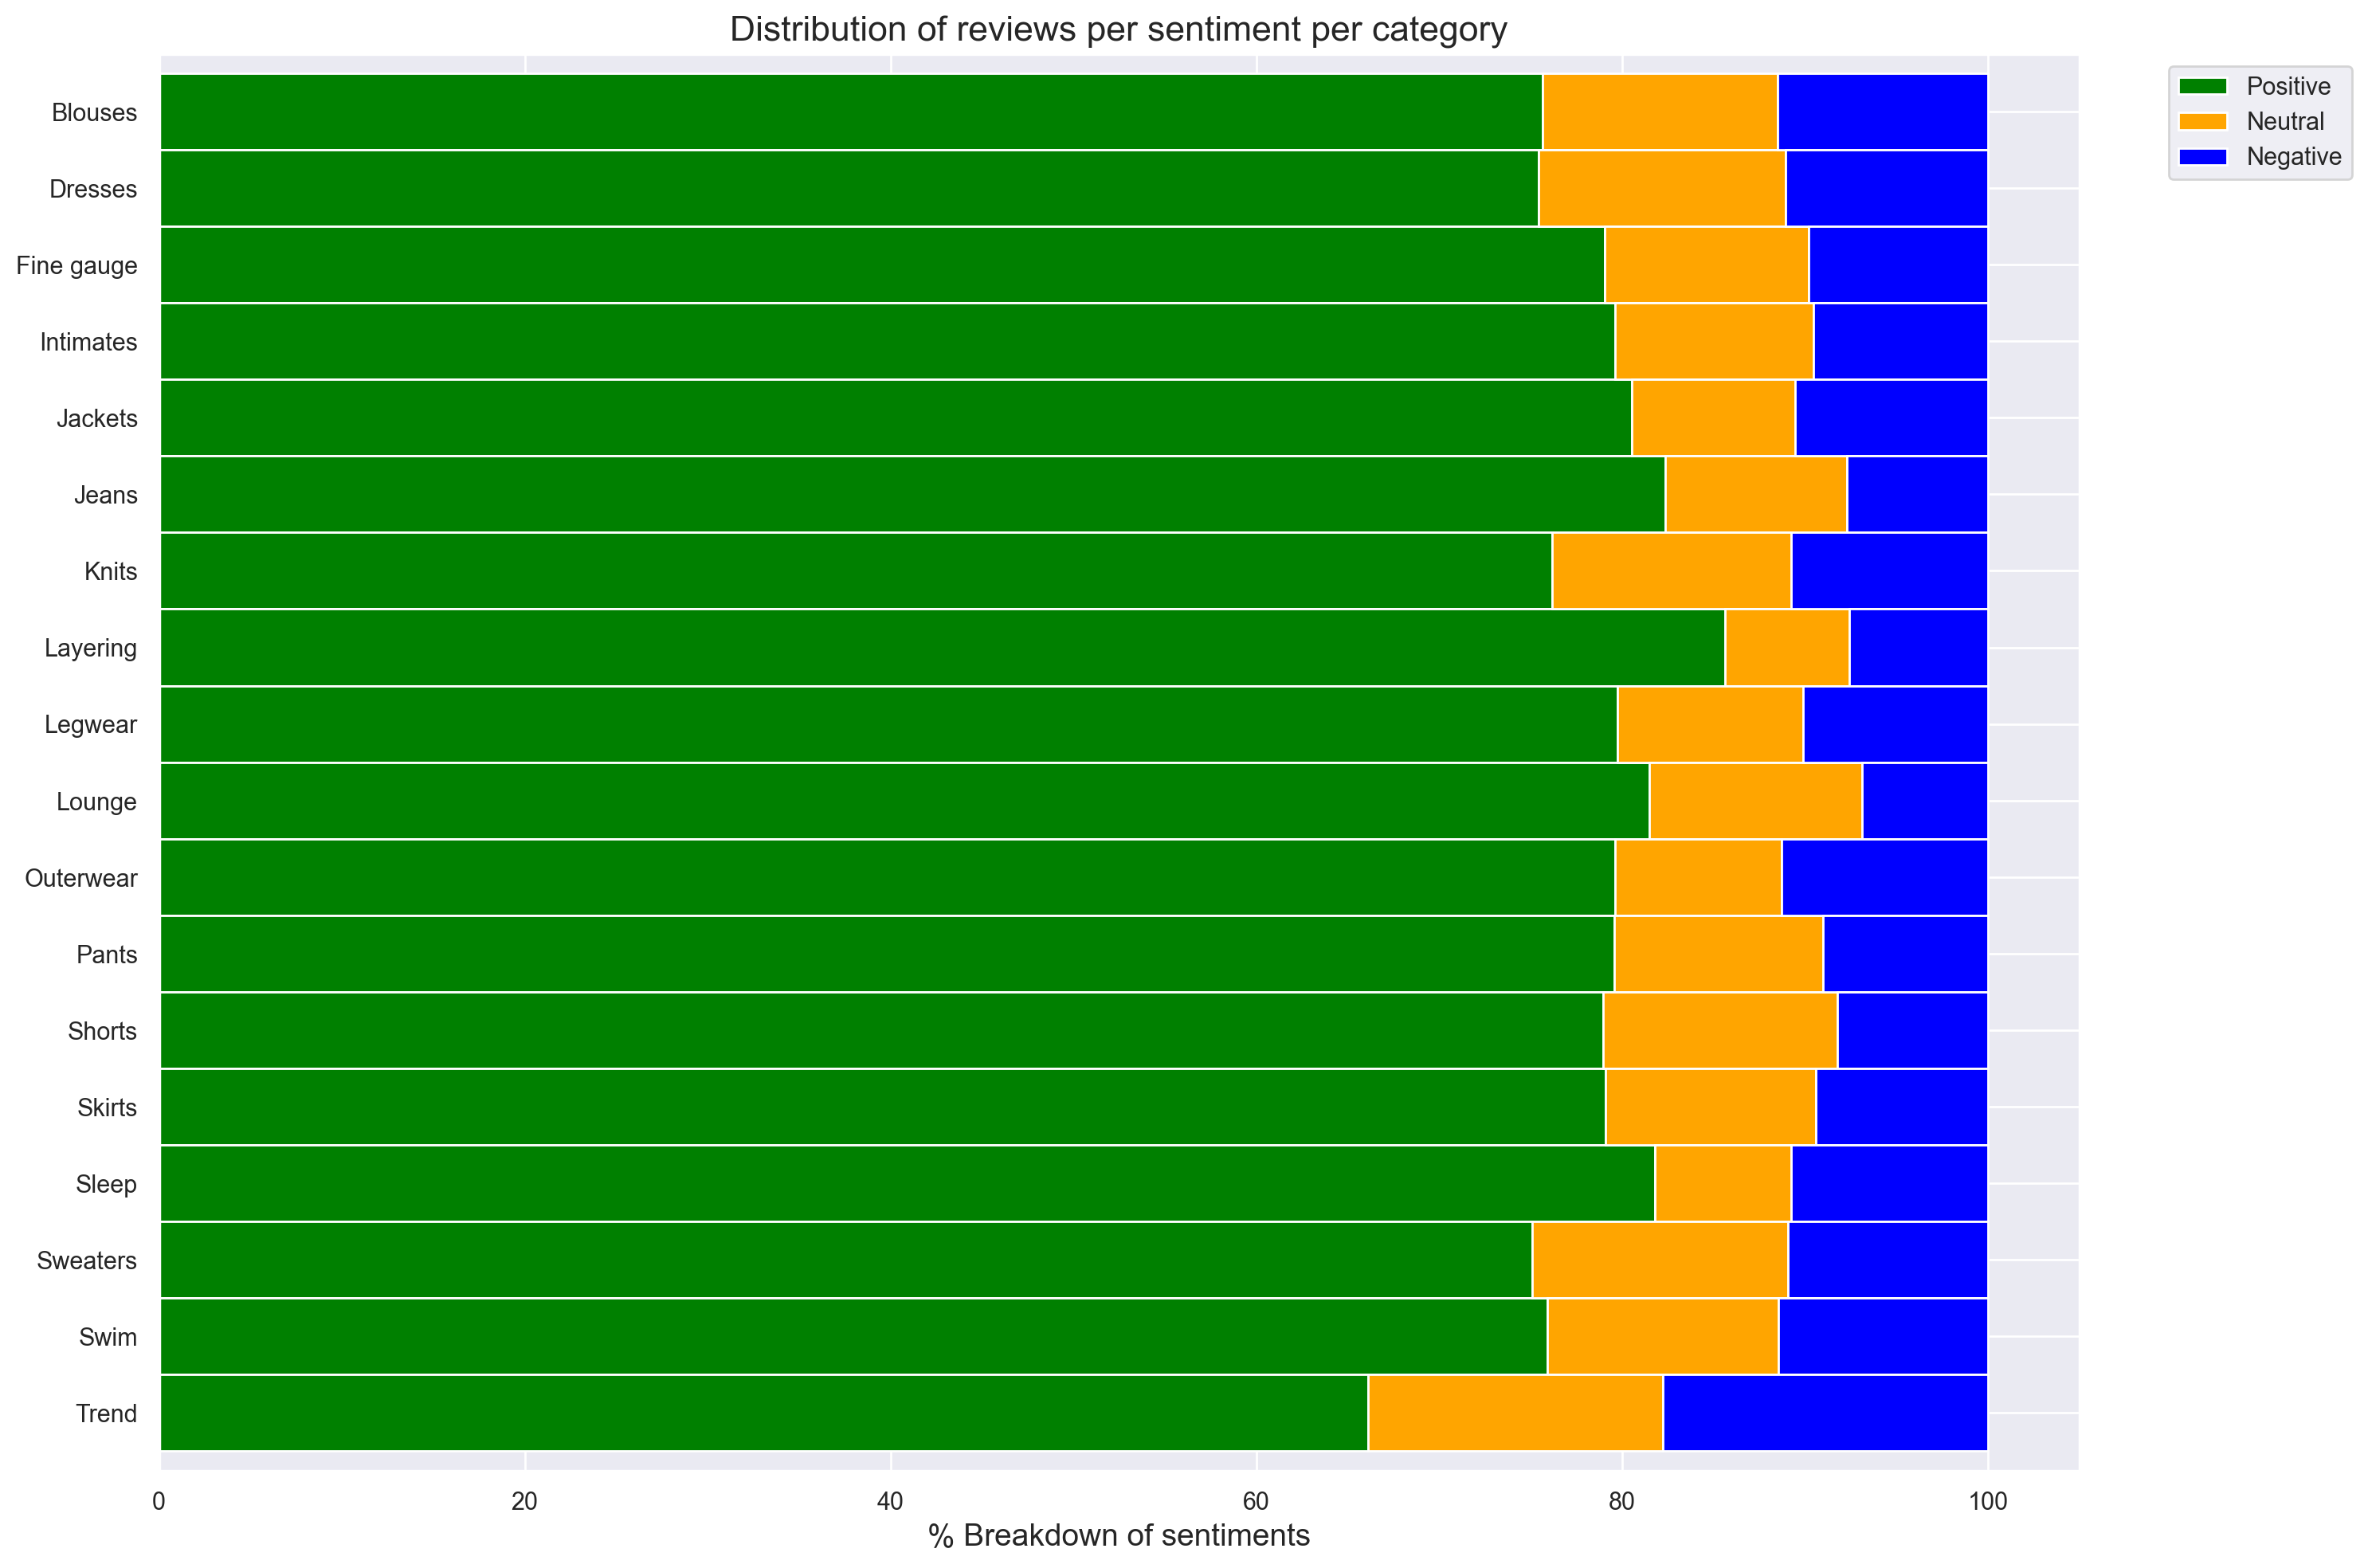

In [60]:
categories = df_distribution_pct.index

# Plot bars
plt.figure(figsize=(10,5))

df_distribution_pct.plot(kind="barh", 
                         stacked=True, 
                         edgecolor='white',
                         width=1.0,
                         color=['green', 
                                'orange', 
                                'blue'])

plt.title("Distribution of reviews per sentiment per category", 
          fontsize='16')

plt.legend(bbox_to_anchor=(1.04,1), 
           loc="upper left",
           labels=['Positive', 
                   'Neutral', 
                   'Negative'])

plt.xlabel("% Breakdown of sentiments", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()

# Do not change the figure name - it is used for grading purposes!
plt.savefig('distribution_sentiment_per_category.png', dpi=300)
plt.show()

In [61]:
# Upload image to S3 bucket
sess.upload_data(path='distribution_sentiment_per_category.png', bucket=bucket, key_prefix="images")

's3://mobucketsagemaker/images/distribution_sentiment_per_category.png'

Analysis by word count



In [62]:
statement_num_words = """
    SELECT CARDINALITY(SPLIT(review_body, ' ')) as num_words
    FROM {}
""".format(table_name)

print(statement_num_words)


    SELECT CARDINALITY(SPLIT(review_body, ' ')) as num_words
    FROM reviews



In [63]:
%%time
df_num_words = wr.athena.read_sql_query(
    sql=statement_num_words,
    database=database_name
)

CPU times: total: 281 ms
Wall time: 10.8 s


In [64]:
summary = df_num_words["num_words"].describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])
summary

count      22626.0
mean     62.709847
std      29.993735
min            2.0
10%           22.0
20%           33.0
30%           42.0
40%           51.0
50%           61.0
60%           72.0
70%           86.0
80%           97.0
90%          103.0
100%         122.0
max          122.0
Name: num_words, dtype: Float64

Plot the distribution of the words number per review

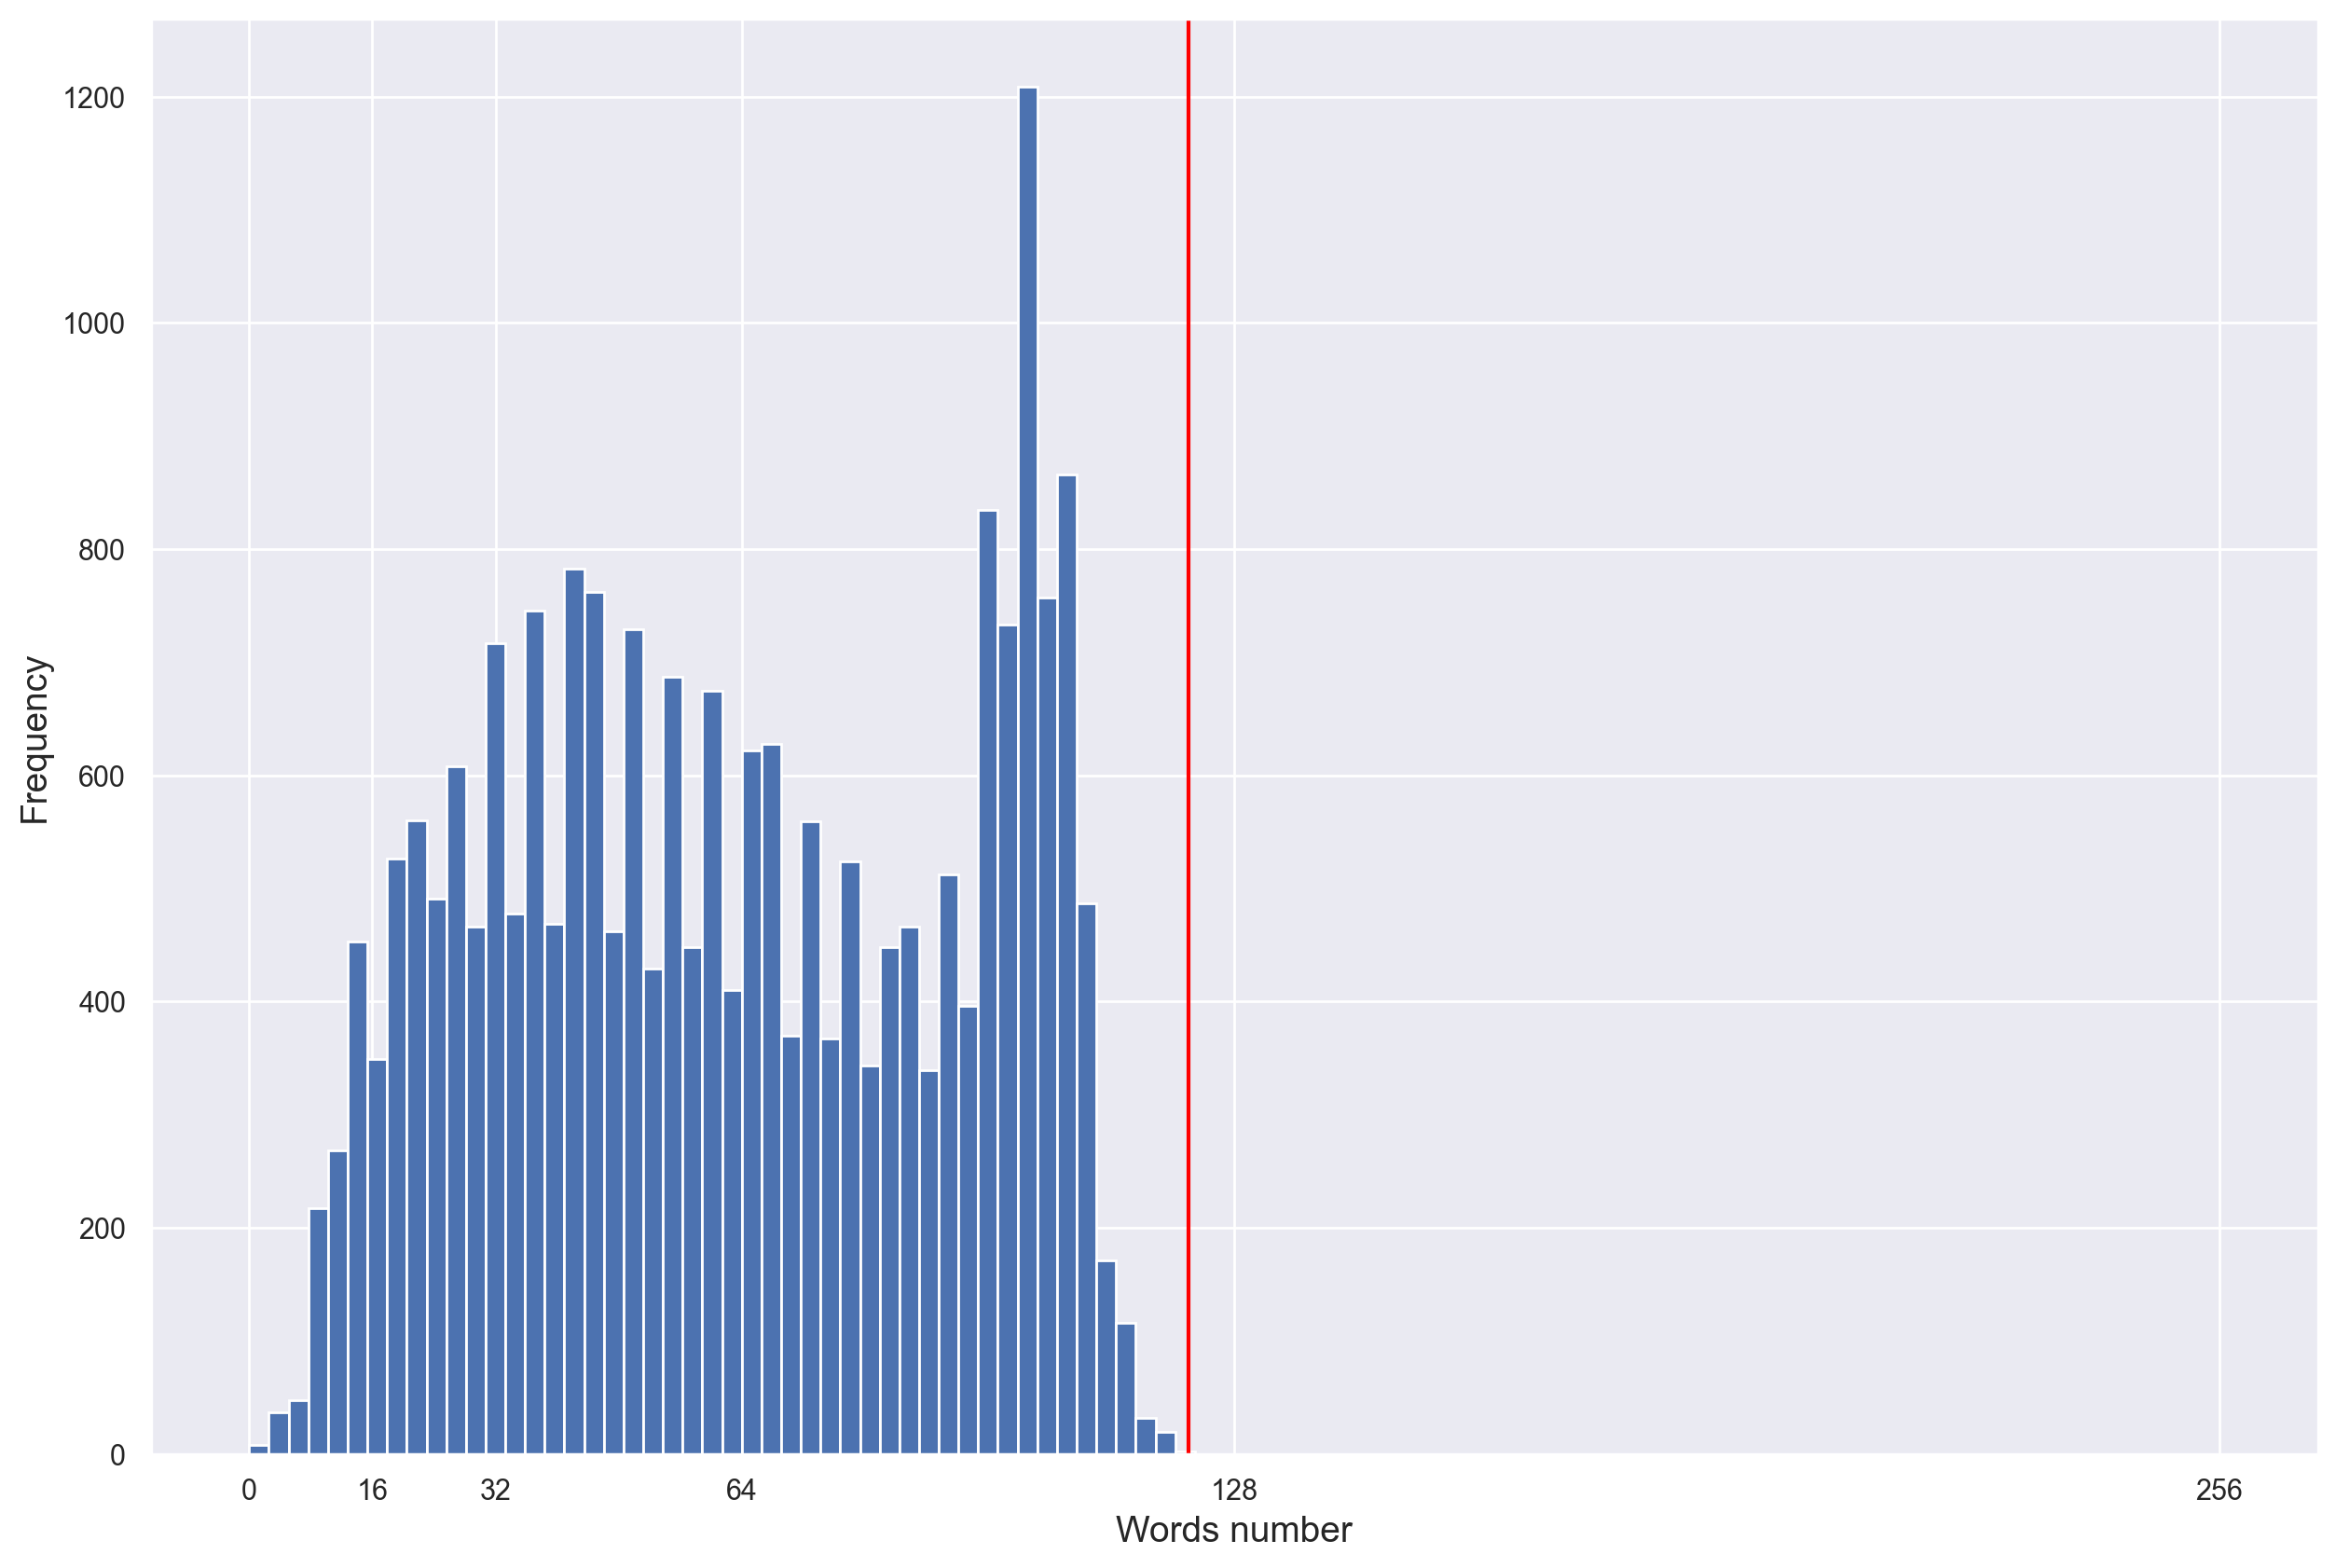

In [66]:
df_num_words["num_words"].plot.hist(xticks=[0, 16, 32, 64, 128, 256], bins=100, range=[0, 256]).axvline(
    x=summary["100%"], c="red"
)

plt.xlabel("Words number", fontsize='14')
plt.ylabel("Frequency", fontsize='14')
plt.savefig('distribution_num_words_per_review.png', dpi=300)
plt.show()

In [67]:
# Upload image to S3 bucket
sess.upload_data(path='distribution_num_words_per_review.png', bucket=bucket, key_prefix="images")

's3://mobucketsagemaker/images/distribution_num_words_per_review.png'

In [69]:
!aws s3 cp ./sentiment-aws_me.ipynb s3://$bucket/sentiment-aws_me.ipynb

Completed 256.0 KiB/689.7 KiB (71.3 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/689.7 KiB (86.5 KiB/s) with 1 file(s) remaining
Completed 689.7 KiB/689.7 KiB (81.2 KiB/s) with 1 file(s) remaining
upload: .\sentiment-aws_me.ipynb to s3://mobucketsagemaker/sentiment-aws_me.ipynb
